In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


# Variance of SAXS data

There has been a long discussion about the validity (or not) of pixel splitting regarding the propagation of errors.

## System under study

Let's do a numerical experiment, simulating the following experiment:

* Detector: 1024x1024 square pixels of 100µm each, assumed to be poissonian. 
* Geometry: The detector is placed at 1m from the sample, the beam center is in the corner of the detector
* Sample: It is a set of spheres of Rg = 1nm, following the Guinier's law
* Intensity: the maximum signal on the detector is 100 000 photons.
* Wavelength: 1 Angstrom
* During the whole studdy, the solid-angle correction will be discarded

Now we define some constants for the studdy:

In [2]:
pix = 100e-6
shape = (1024, 1024)
npt = 3000
nimg = 1000
wl = 1e-10
I0 = 1e5
Rg = 1.
kwarg = {"npt":npt, "method": "full_csr", "correctSolidAngle":False}

In [3]:
import pyFAI
from pyFAI.detectors import Detector
detector = Detector(pix, pix)
detector.shape = detector.max_shape = shape
print(detector)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m


In [4]:
ai = pyFAI.AzimuthalIntegrator(dist=1, detector=detector)
ai.wavelength = wl
print(ai)

Detector Detector	 Spline= None	 PixelSize= 1.000e-04, 1.000e-04 m
Wavelength= 1.000000e-10m
SampleDetDist= 1.000000e+00m	PONI= 0.000000e+00, 0.000000e+00m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1000.000mm	Center: x=0.000, y=0.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


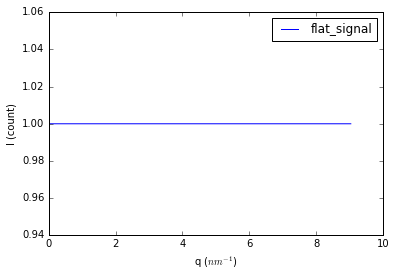

In [5]:
q, I = ai.integrate1d(numpy.ones(detector.shape), **kwarg)
plot(q, I, label="flat_signal")
legend()
xlabel("q ($nm^{-1}$)")
ylabel("I (count)")

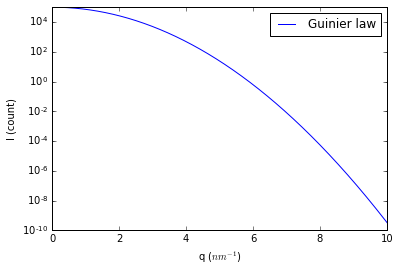

In [6]:
#Using Guinier law:
q = numpy.linspace(0, 10, npt)
I = I0* numpy.exp(-q*q*Rg*Rg/3.)
semilogy(q, I, label="Guinier law")
xlabel("q ($nm^{-1}$)")
ylabel("I (count)")
legend()

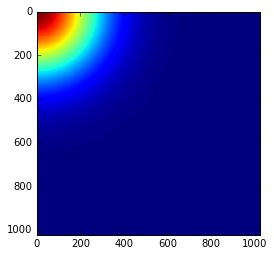

In [7]:
#Reconstruction of diffusion image:
img_theo = ai.calcfrom1d(q, I, dim1_unit="q_nm^-1", correctSolidAngle=False)
imshow(img_theo)
#semilogy(*ai.integrate1d(img_theo, **kwarg))

In [8]:
%%time
# Now construct the large dataset from poissonian statistics
#this is slow and takes a lot of memory !
import numpy
dataset = numpy.empty(shape+(nimg,), dtype=numpy.int32)
print(dataset.size/(2**20), "MBytes", dataset.shape)
#this is not efficient ...
for i in range(shape[0]):
    for j in range(shape[1]):
        dataset[i, j, :] = numpy.random.poisson(img_theo[i,j], nimg)
        

1000.0 MBytes (1024, 1024, 1000)
CPU times: user 2min 28s, sys: 1.87 s, total: 2min 30s
Wall time: 2min 30s


Error max: 35.6948652084 Error mean 0.000138846201983
Deviation on variance 16102.6773955


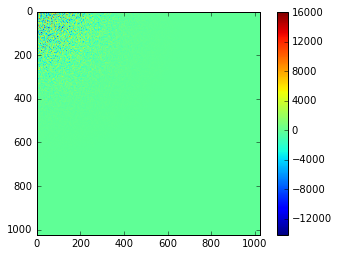

In [9]:
img_avg = dataset.mean(axis=-1)
img_std = dataset.std(axis=-1)
error = img_theo - img_avg
print("Error max:", abs(error.max()), "Error mean", abs(error.mean()))
print("Deviation on variance", abs(img_std**2-img_theo).max())
imshow(img_std**2-img_avg)
colorbar()

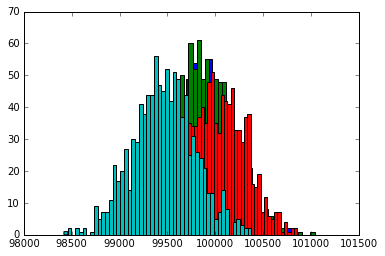

In [10]:
#Few histogram of intensity
hist(dataset[10,0,:],50)
hist(dataset[0,10,:],50)
hist(dataset[0,0,:],50)
hist(dataset[20,0,:],50)
print()

In [11]:
%%time
avg = numpy.empty((nimg, npt))
err = numpy.empty((nimg, npt))
for i in range(nimg):
    q,ii,e = ai.integrate1d(dataset[:, :, i], error_model="poisson", **kwarg)
    avg[i] = ii
    err[i] = e

CPU times: user 5min 34s, sys: 688 ms, total: 5min 35s
Wall time: 56 s


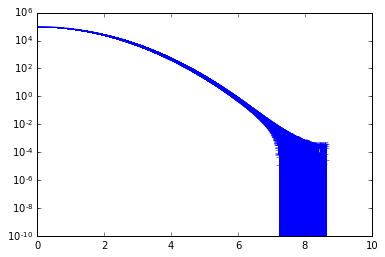

In [12]:
signal_avg = avg.mean(axis=0)
error_avg = numpy.sqrt((err**2).mean(axis=0))
errorbar(q, signal_avg, error_avg)
yscale("log")

In [13]:
q, signal_all, error_all = ai.integrate1d(img_avg, variance=img_std**2, **kwarg)

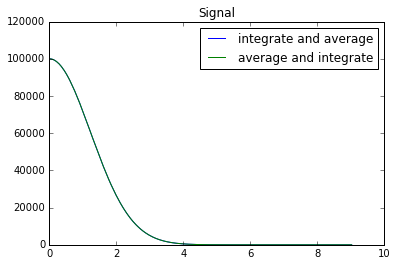

In [14]:
plot(q, signal_avg, label="integrate and average")
plot(q, signal_all, label="average and integrate")
title("Signal")
legend()

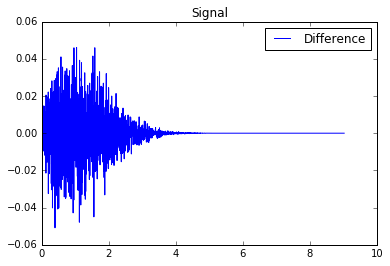

In [15]:
plot(q, signal_all-signal_avg, label="Difference")
title("Signal")
legend()

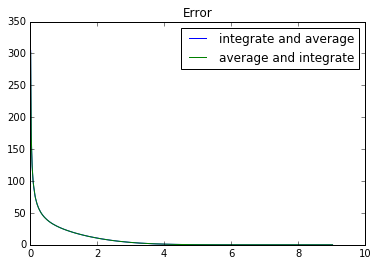

In [16]:
plot(q, error_avg, label="integrate and average")
plot(q, error_all, label="average and integrate")
title("Error")
legend()

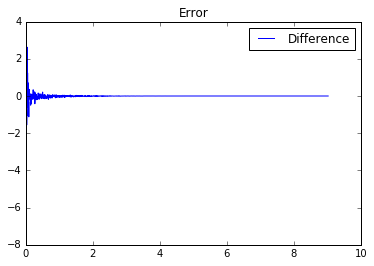

In [17]:
plot(q, error_all-error_avg, label="Difference")
title("Error")
legend()

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


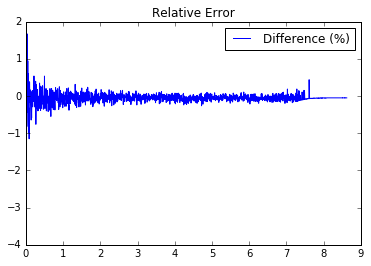

In [18]:
plot(q, 100*(error_all-error_avg)/error_all, label=r"Difference (%)")
title("Relative Error")
legend()

In [19]:
#Comparison with no-splitting:
kw = kwarg.copy()
kw["method"] = "histogram"
kw["npt"] = npt#100 #undersampling to get smth smooth
qc, signalc, errc = ai.integrate1d(img_avg, variance=img_std**2, **kw)
signal_nosplit = numpy.interp(q, qc, signalc)
err_nosplit = numpy.interp(q, qc, errc)

/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


Average deviation of error (%) -1.32722470917 median 0.0262507664767


/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/scisoft/users/jupyter/jupy34/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


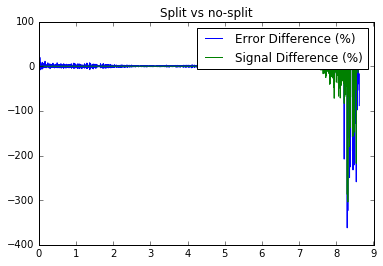

In [20]:
plot(q, 100*(err_nosplit-error_avg)/err_nosplit, label=r"Error Difference (%)")
plot(q, 100*(signal_nosplit-signal_avg)/signal_nosplit, label=r"Signal Difference (%)")
title("Split vs no-split")
legend()
with_nan = 100*(err_nosplit-error_avg)/err_nosplit
without = with_nan[numpy.isfinite(with_nan)]
print("Average deviation of error (%)",without.mean(),"median", numpy.median(without))

## Conclusion

With moderate pixels splitting (here every pixel is plit over 2/3 bins), the difference with *validated* techniques is hardly detectable and null in average.